In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


#### Load libraries 

In [2]:
import os
import sys
sys.path.append('../src')

os.chdir('drive/My Drive')
ROOT = os.getcwd()
os.chdir(ROOT + '/Colab Notebooks')

from project_utilities.config import DATA_DIR_RAW

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from sklearn.metrics import confusion_matrix

import itertools

#### Verify that the GPU is available

In [4]:
print(f'TensorFlow Version: {tf.__version__}')
print(f'Using CUDA: {tf.test.is_built_with_cuda()}')
print(f'Using GPU: {tf.config.list_physical_devices("GPU")}')
# print("Num of GPUs available: ", len(tf.test.gpu_device_name()))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

tf.config.experimental.set_memory_growth(physical_devices[0], True)

TensorFlow Version: 2.3.0
Using CUDA: True
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


#### These two functions come from SKLearn

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          name=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(ROOT + '/artifacts/charts/' + name + '_cm.png')
 

In [6]:
   
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()    

#### Data Generator wrapper. The Keras ImageDataGenerator takes a preprocessing_function. In this case it is using the vgg16 preprocessor which applies the image preprocessing that the model was originally trained with.

In [7]:

def datagen(path, shuffle=True):
    batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=10, shuffle=shuffle)
    return batches

#### Put paths to the data in variables

In [8]:
train_path = '../data/raw/train'
valid_path = '../data/raw/valid'
test_path = '../data/raw/test'


#### Generate the data for modeling

In [9]:
          
train_batch = datagen(train_path)
valid_batch = datagen(valid_path)
test_batch = datagen(test_path, shuffle=False)

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Import VGG 16 Model and print a summary of the architecture.

In [14]:

vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()


553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

#### The summary shows that there are 138,257.544 trainable paremeters and 1000 different classes. 

#### Create a new sequential model. Then iterrate over the layers of the VGG 16 model, adding all but the final layer to the new model. The sequential model is easier to work with tha using a functional model. Building a functional model will be left as a future endevour.

In [15]:
# Create a Keras sequential model
seq_vgg16_model = Sequential()

# Iterrrate over the vgg16 model and add layers to the new model. Exclude final layer.
for layer in vgg16_model.layers[:-1]:
    seq_vgg16_model.add(layer)


#### Now iterrate over the layers in the mew model and freeze each layer.

In [16]:

for layer in seq_vgg16_model.layers:
    layer.trainable = False


#### Now add the new final layer with only two outputs. Print a summary of the architecture.

In [17]:

seq_vgg16_model.add(Dense(units=2, activation='softmax'))
seq_vgg16_model.summary()    

seq_vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

#### The new model has 8,194 trainable parameters, and two classes.

#### Train the new model.

In [18]:

mod_history = seq_vgg16_model.fit(x=train_batch,
          steps_per_epoch=len(train_batch),
          validation_data=valid_batch,
          validation_steps=len(valid_batch),
          epochs=10,
          verbose=2
)


Epoch 1/10
419/419 - 1970s - loss: 0.2405 - accuracy: 0.8973 - val_loss: 0.1568 - val_accuracy: 0.9417
Epoch 2/10
419/419 - 66s - loss: 0.1164 - accuracy: 0.9579 - val_loss: 0.1343 - val_accuracy: 0.9465
Epoch 3/10
419/419 - 67s - loss: 0.0948 - accuracy: 0.9661 - val_loss: 0.1304 - val_accuracy: 0.9484
Epoch 4/10
419/419 - 67s - loss: 0.0835 - accuracy: 0.9668 - val_loss: 0.1191 - val_accuracy: 0.9513
Epoch 5/10
419/419 - 67s - loss: 0.0759 - accuracy: 0.9744 - val_loss: 0.1172 - val_accuracy: 0.9561
Epoch 6/10
419/419 - 67s - loss: 0.0689 - accuracy: 0.9742 - val_loss: 0.1218 - val_accuracy: 0.9513
Epoch 7/10
419/419 - 66s - loss: 0.0650 - accuracy: 0.9775 - val_loss: 0.1105 - val_accuracy: 0.9532
Epoch 8/10
419/419 - 67s - loss: 0.0587 - accuracy: 0.9797 - val_loss: 0.1111 - val_accuracy: 0.9551
Epoch 9/10
419/419 - 68s - loss: 0.0546 - accuracy: 0.9816 - val_loss: 0.1079 - val_accuracy: 0.9570
Epoch 10/10
419/419 - 68s - loss: 0.0512 - accuracy: 0.9816 - val_loss: 0.1096 - val_accu

#### Save the model.

In [49]:
seq_vgg16_model.save(ROOT + '/artifacts/models/seq_vgg16_model.h5')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

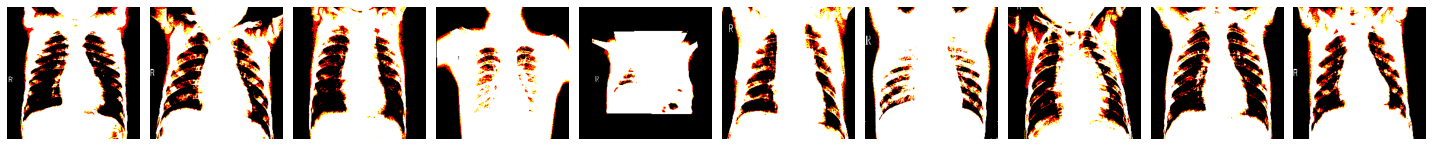

In [20]:

test_imgs, test_labels = next(test_batch)
plotImages(test_imgs)
#print(test_labels)


#### Make predictions on the test data.

In [19]:

predictions = seq_vgg16_model.predict(x=test_batch, steps=len(test_batch), verbose=0)


In [50]:

np.save(ROOT + '/artifacts/predictions/seq_vgg16_model_preds.py', predictions)

#test_batch.class_indices


#### Plot a confusion matrix

Confusion matrix, without normalization
[[163  71]
 [  7 383]]


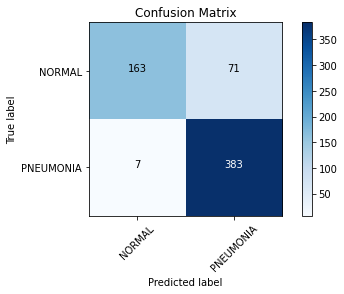

In [20]:

cm = confusion_matrix(y_true=test_batch.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', name='seq_vgg16_model')



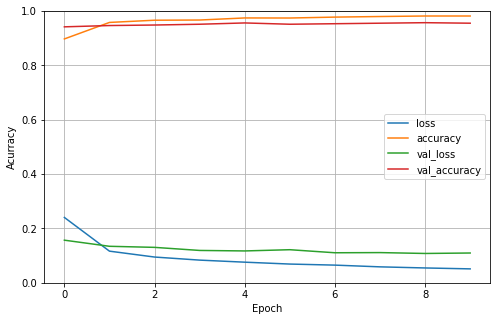

In [21]:
import pandas as pd

pd.DataFrame(mod_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.xlabel('Epoch')
plt.ylabel('Acurracy')
plt.savefig(ROOT + '/artifacts/charts/seq_vgg16_model_av.png') 
plt.show()

#### Training Loss and Accuracy

In [37]:
seq_vgg16_model.evaluate(train_batch)

419/419 [==============================] - 57s 135ms/step - loss: 0.0246 - accuracy: 0.9950


[0.024569950997829437, 0.9949820637702942]

#### Validation Loss and Accuracy

In [38]:
seq_vgg16_model.evaluate(valid_batch)

105/105 [==============================] - 14s 132ms/step - loss: 0.1048 - accuracy: 0.9589


[0.10484474152326584, 0.958930253982544]

#### Testing Loss and Accuracy

In [39]:
seq_vgg16_model.evaluate(test_batch)

63/63 [==============================] - 8s 129ms/step - loss: 0.3668 - accuracy: 0.8686


[0.3667617440223694, 0.8685897588729858]

#### False Negative Rate in Test - When testing for pneumonia

In [48]:
print(f"False negative rate for the test set: {5/390*100}")
print(f"True positive rate for the test set: {385/390*100}")

False negative rate for the test set: 1.282051282051282
True positive rate for the test set: 98.71794871794873


In [ ]:
print(f"True negative rate for the test set: {5/390*100}")

#### Freeze and additional layer

In [11]:
# Create a Keras sequential model
seq_vgg16_model_2 = Sequential()

# Iterrrate over the vgg16 model and add layers to the new model. Exclude final layer.
for layer in vgg16_model.layers[:-1]:
    seq_vgg16_model_2.add(layer)


In [12]:

for layer in seq_vgg16_model_2.layers[:-2]:
    layer.trainable = False


In [13]:

seq_vgg16_model_2.add(Dense(units=2, activation='softmax'))
seq_vgg16_model_2.summary()    

seq_vgg16_model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [14]:

mod_2_history = seq_vgg16_model_2.fit(x=train_batch,
          steps_per_epoch=len(train_batch),
          validation_data=valid_batch,
          validation_steps=len(valid_batch),
          epochs=10,
          verbose=2
)


Epoch 1/10
419/419 - 2343s - loss: 0.1728 - accuracy: 0.9589 - val_loss: 0.0613 - val_accuracy: 0.9733
Epoch 2/10
419/419 - 93s - loss: 0.0702 - accuracy: 0.9823 - val_loss: 1.4422 - val_accuracy: 0.9112
Epoch 3/10
419/419 - 93s - loss: 0.0968 - accuracy: 0.9859 - val_loss: 0.2311 - val_accuracy: 0.9513
Epoch 4/10
419/419 - 93s - loss: 0.0113 - accuracy: 0.9967 - val_loss: 0.1169 - val_accuracy: 0.9819
Epoch 5/10
419/419 - 93s - loss: 3.1420e-04 - accuracy: 1.0000 - val_loss: 0.1316 - val_accuracy: 0.9838
Epoch 6/10
419/419 - 93s - loss: 1.7572e-05 - accuracy: 1.0000 - val_loss: 0.1285 - val_accuracy: 0.9847
Epoch 7/10
419/419 - 93s - loss: 1.4997e-05 - accuracy: 1.0000 - val_loss: 0.1449 - val_accuracy: 0.9847
Epoch 8/10
419/419 - 93s - loss: 1.0747e-06 - accuracy: 1.0000 - val_loss: 0.1481 - val_accuracy: 0.9866
Epoch 9/10
419/419 - 93s - loss: 4.6145e-08 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.9866
Epoch 10/10
419/419 - 93s - loss: 3.3356e-08 - accuracy: 1.0000 - val

#### Save the model

In [15]:
seq_vgg16_model_2.save(ROOT + '/artifacts/models/seq_vgg16_model_2.h5')


#### Make predictions on test set

In [16]:

predictions_2 = seq_vgg16_model_2.predict(x=test_batch, steps=len(test_batch), verbose=0)

#### Save predictions

In [17]:

np.save(ROOT + '/artifacts/predictions/seq_vgg16_model_2_preds.py', predictions_2)

#test_batch.class_indices


#### Plot confusion matrix

Confusion matrix, without normalization
[[163  71]
 [  2 388]]


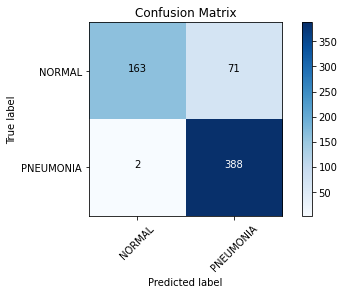

In [31]:

cm = confusion_matrix(y_true=test_batch.classes, y_pred=np.argmax(predictions_2, axis=-1))
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', name='seq_vgg16_model_2')



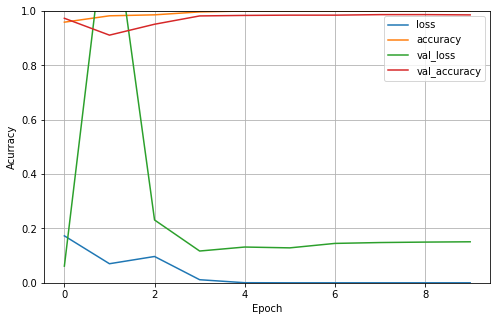

In [32]:
import pandas as pd

pd.DataFrame(mod_2_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.xlabel('Epoch')
plt.ylabel('Acurracy')
plt.savefig(ROOT + '/artifacts/charts/seq_vgg16_model_2_av.png')
plt.show()

#### Training Loss and Accuracy

In [20]:
seq_vgg16_model_2.evaluate(train_batch)

419/419 [==============================] - 81s 192ms/step - loss: 2.7459e-08 - accuracy: 1.0000


[2.7459289952957988e-08, 1.0]

#### Validation Loss and Acurracy

In [22]:
seq_vgg16_model_2.evaluate(valid_batch)

105/105 [==============================] - 20s 191ms/step - loss: 0.1509 - accuracy: 0.9857


[0.1508851945400238, 0.9856733679771423]

#### Testing Loss and Acurracy

In [23]:
seq_vgg16_model_2.evaluate(test_batch)

63/63 [==============================] - 12s 196ms/step - loss: 2.4424 - accuracy: 0.8830


[2.4423768520355225, 0.8830128312110901]